In [5]:
import numpy as np
import torch
from torch import nn, optim
import random
from collections import Counter
import matplotlib.pyplot as plt

In [3]:
EMBEDDING_DIM = 2
PRINT_EVERY = 1000
EPOCHS = 1000
BATCH_SIZE = 5
N_SAMPLES = 3           # number of negative samples
WINDOW_SIZE = 5         # previous + current + future
FREQ = 0                # the count lt FREQ will be deleted
DELETE_WORDS = False    # whether to use subsampling

In [1]:
text = "I like dog i like cat i like animal dog cat animal apple cat dog like dog fish milk like dog \
cat eyes like i like apple apple i hate apple i movie book music like cat dog hate cat dog like"

In [41]:
''' delete low-frequency words '''
def preprocess(text, FREQ):
    text = text.lower()
    words = text.split()
    words_counts = Counter(words)
    trimmed_words = [word for word in words if words_counts[word] >= FREQ]
    return trimmed_words
words = preprocess(text, FREQ)

''' construct vocabulary '''
vocab = set(words)
word2idx = dict((item, i)for i, item in enumerate(vocab))
idx2word = dict((i, item)for i, item in enumerate(vocab))

''' calculate each word(actual is its idx) frequency '''
words_idx = [word2idx[word] for word in words]
words_counts = Counter(words_idx)
sentLength = len(words)  
words_freq = dict((item[0], item[1]/sentLength) for item in words_counts.items())

''' whether to use subsampling: 1-sqrt(t/f) '''
if DELETE_WORDS:
    t = 1e-5
    prob_drop = dict((item[0], np.sqrt(t/item[1])) for item in words_freq)
    train_words = [w for w in words_idx if random.random() < prob_drop[w]]
else:
    train_words = words_idx

''' negative sampling: fi^0.75 / sum(f^0.75) '''
words_freq = np.array(list(words_freq.values()))
unigram_dist = words_freq/sum(words_freq)   # normalization reason: when apply subsampling, the sum(words_freq) may lt 1
noise_dist = torch.from_numpy(unigram_dist ** 0.75 / np.sum(unigram_dist ** 0.75))

''' get bag of words around center position '''
def get_target(words, idx, WINDOW_SIZE):
    target_window = np.random.randint(1, WINDOW_SIZE+1)     # randomly choose a window_size \in [1, windows_size], see Paper: skip-gram
    start_pos = idx - target_window if (idx-target_window) > 0 else 0
    end_pos = idx + target_window
    targets = set(words[start_pos:idx] + words[idx+1: end_pos+1])
    return list(targets)    # return bag of words

''' divide a sentence into batches'''
def get_batch(words, BATCH_SIZE, WINDOW_SIZE):
    n_batches = len(words) // BATCH_SIZE
    words = words[: n_batches*BATCH_SIZE]       # it should retain the rightmost part
    for idx in range(0, len(words), BATCH_SIZE):
        batch_x, batch_y = [], []
        batch = words[idx: idx+BATCH_SIZE]
        for i in range(len(batch)):
            x = batch[i]
            y = get_target(batch, i, WINDOW_SIZE)   # for each center posiiton, randomly choose a window_size
            batch_x.extend([x]*len(y))  # one center position corresponds to its context bag of words
            batch_y.extend(y)
        yield batch_x, batch_y


loss: tensor(1.9661, grad_fn=<NegBackward>)
loss: tensor(1.7857, grad_fn=<NegBackward>)
loss: tensor(1.7218, grad_fn=<NegBackward>)
loss: tensor(1.8517, grad_fn=<NegBackward>)
loss: tensor(1.7886, grad_fn=<NegBackward>)
loss: tensor(2.0628, grad_fn=<NegBackward>)
loss: tensor(1.7027, grad_fn=<NegBackward>)
loss: tensor(1.9780, grad_fn=<NegBackward>)


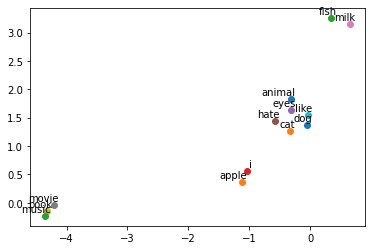

In [81]:
''' define skip-gram '''
class SkipGramNeg(nn.Module):
    def __init__(self, n_vocab, n_embed, noise_dist):
        super().__init__()
        self.n_vocab = n_vocab
        self.n_embed = n_embed
        self.noise_dist = noise_dist
        self.in_embed = nn.Embedding(n_vocab, n_embed)      # embedding between input -- projection
        self.out_embed = nn.Embedding(n_vocab, n_embed)     # embedding between projection -- output
        self.in_embed.weight.data.uniform_(-1, 1)   # initialization
        self.out_embed.weight.data.uniform_(-1, 1)   # initialization
    
    def forward_input(self, input_words):
        input_vecs = self.in_embed(input_words)     # loopup using a list of indices
        return input_vecs

    def forward_output(self, output_words):
        output_vecs = self.out_embed(output_words)
        return output_vecs
    
    def forward_noise(self, size, N_SAMPLES):
        noise_dist = self.noise_dist
        noise_words = torch.multinomial(noise_dist, size*N_SAMPLES, replacement=True)   # batch * N_SAMPLES
        noise_vecs = self.out_embed(noise_words).view(size, N_SAMPLES, self.n_embed)    # batch * N_SAMPLES * n_embed
        return noise_vecs

''' define loss function '''
class NegativeSamplingLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_vecs, output_vecs, noise_vecs):
        BATCH_SIZE, embed_size = input_vecs.shape
        input_vecs = input_vecs.view(BATCH_SIZE, embed_size, 1)
        output_vecs = output_vecs.view(BATCH_SIZE, 1, embed_size)   
        out_loss = torch.bmm(output_vecs, input_vecs).sigmoid().log()           # positive loss = log(sigmoid(y_i))
        out_loss = out_loss.squeeze()

        noise_loss = torch.bmm(noise_vecs.neg(), input_vecs).sigmoid().log()    # imply netative sampling, log(sigmoid(y_i))
        noise_loss = noise_loss.squeeze().sum(1)

        return -(out_loss + noise_loss).mean()  # batch loss

model = SkipGramNeg(len(word2idx), EMBEDDING_DIM, noise_dist=noise_dist)
criterion = NegativeSamplingLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

steps = 0
for e in range(EPOCHS):
    for input_words, target_words in get_batch(train_words, BATCH_SIZE, WINDOW_SIZE):
        steps += 1
        inputs, targets = torch.LongTensor(input_words), torch.LongTensor(target_words)     # Tensor whose dtype == long
        input_vecs = model.forward_input(inputs)
        output_vecs = model.forward_output(targets)
        size, _ = input_vecs.shape
        noise_vecs = model.forward_noise(size, N_SAMPLES)       # negative sampling
        loss = criterion(input_vecs, output_vecs, noise_vecs)   # torch.nn.Module implement in __call__ and call the forward function
        if steps % PRINT_EVERY == 0:
            print('loss:', loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


for i, w in idx2word.items():
    vectors = model.state_dict()["in_embed.weight"]
    x,y = float(vectors[i][0]),float(vectors[i][1])
    plt.scatter(x,y)
    plt.annotate(w, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()


In [72]:
import torch
import torch.nn.functional as f
from torch import nn
a = torch.randn(3, 4, 5, 5)
conv = nn.Conv2d(4, 2, (1,2))
conv(a)





tensor([[[[ 0.4098,  0.0494, -0.1591, -0.9029],
          [-0.6837, -0.3478,  0.0487,  0.2964],
          [-0.5611, -0.4156, -0.6910,  0.2215],
          [-1.3175, -0.1324,  0.1285, -0.0066],
          [-0.4000, -0.2212, -0.1650, -0.2725]],

         [[-0.5775, -0.3915,  0.4130,  0.8296],
          [ 0.1720,  0.4784, -0.6678,  0.0946],
          [-0.2314, -0.3830,  0.0456, -0.9799],
          [ 0.2910, -0.1976, -0.3945,  0.0170],
          [-0.3979, -0.3624,  0.2322, -0.1351]]],


        [[[ 0.3362, -0.9729,  0.4458, -0.2397],
          [-0.1459, -0.2312, -0.3671,  0.4335],
          [ 0.3713, -0.5303, -0.9921,  0.5703],
          [ 0.1389, -0.9491,  0.3699, -0.4149],
          [-0.5686,  0.1639, -0.4453, -0.8903]],

         [[ 0.3136,  0.1557, -0.5978,  0.3672],
          [-0.1177, -0.3365, -0.1406, -0.3333],
          [-0.1976, -0.0430, -0.0587, -0.6449],
          [-0.6685,  0.2573, -0.9275, -0.9335],
          [-0.1489, -0.6988,  0.3509,  0.3746]]],


        [[[ 0.1927, -0.2749,